In [ ]:
! kaggle

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
! mv kaggle.json /root/.kaggle/kaggle.json
! chmod 600 /root/.kaggle/kaggle.json
! kaggle
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: too few arguments
100% 2.29G/2.29G [00:41<00:00, 36.2MB/s]
100% 2.29G/2.29G [00:41<00:00, 59.7MB/s]


In [ ]:
! unzip -qq chest-xray-pneumonia.zip

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os
import numpy as np
import matplotlib.cm as cm
from IPython.display import Image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
labels = ['NORMAL' , 'PNEUMONIA']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/chest_xray/train')
test = get_training_data( '/content/chest_xray/test')
val = get_training_data( '/content/chest_xray/val')


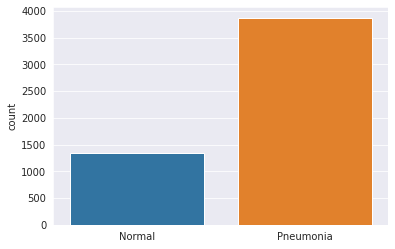

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Normal")
    else:
        l.append("Pneumonia")

sns.countplot(l)

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255


In [ ]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:

datagen = ImageDataGenerator(
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1, 
        height_shift_range=0.1,)  


datagen.fit(x_train)

In [ ]:
model=Sequential()
# 1.layer
model.add(Conv2D(16,(3,3),activation='relu',padding='same',input_shape=(150,150,1)))
model.add(Conv2D(16,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D((2,2)))

# 2.layer
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D((2,2)))

# 3.layer
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D((2,2)))

# 4.layer
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D((2,2)))

# 5.layer
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 150, 150, 16)      160       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 37, 37, 64)       

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=4, mode='auto')

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 , validation_data = datagen.flow(x_val, y_val),callbacks=[checkpoint])

Epoch 1/10
163/163 [==============================] - 10s 61ms/step - loss: 0.5467 - accuracy: 0.7396 - val_loss: 0.7487 - val_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 0.74871, saving model to model.h5
Epoch 2/10
163/163 [==============================] - 10s 59ms/step - loss: 0.4494 - accuracy: 0.7914 - val_loss: 0.6819 - val_accuracy: 0.6250

Epoch 00002: val_loss improved from 0.74871 to 0.68194, saving model to model.h5
Epoch 3/10
163/163 [==============================] - 10s 59ms/step - loss: 0.4313 - accuracy: 0.8002 - val_loss: 0.6289 - val_accuracy: 0.7500

Epoch 00003: val_loss improved from 0.68194 to 0.62886, saving model to model.h5
Epoch 4/10
163/163 [==============================] - 9s 58ms/step - loss: 0.3982 - accuracy: 0.8229 - val_loss: 0.4764 - val_accuracy: 0.8125

Epoch 00004: val_loss improved from 0.62886 to 0.47636, saving model to model.h5
Epoch 5/10
163/163 [==============================] - 9s 58ms/step - loss: 0.3509 - accuracy: 0.8485 

In [ ]:
import keras
model1=keras.models.load_model("model.h5")
#model1.evaluate(x_test,y_test)

print("Loss of the model is - " , model1.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model1.evaluate(x_test,y_test)[1]*100 , "%")

624/624 [==============================] - 1s 2ms/step
Loss of the model is -  27.934714005543636 %
624/624 [==============================] - 0s 332us/step
Accuracy of the model is -  89.74359035491943 %


In [ ]:
predictions = model1.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))


                     precision    recall  f1-score   support

   Normal (Class 0)       0.88      0.85      0.86       234
Pneumonia (Class 1)       0.91      0.93      0.92       390

           accuracy                           0.90       624
          macro avg       0.89      0.89      0.89       624
       weighted avg       0.90      0.90      0.90       624



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[198,  36],
       [ 28, 362]])

In [ ]:
from sklearn.metrics import roc_curve , roc_auc_score
y_pred_keras =model1.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(roc_auc_score(y_test, y_pred_keras))

0.9559281174665789


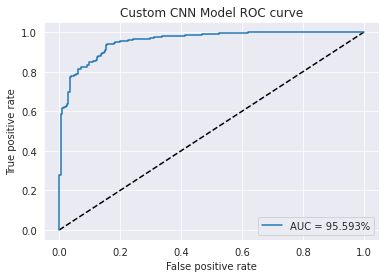

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}%'.format(auc_keras*100))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Custom CNN Model ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [ ]:
!pip uninstall keras-vis
!pip install https://github.com/raghakot/keras-vis/archive/master.zip

In [ ]:
from vis.visualization import visualize_cam
from vis.utils import utils
penultimate_layer_idx = utils.find_layer_idx(model1, "conv2d_30") 

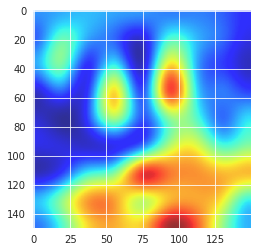

In [ ]:
plt.imshow(visualize_cam(model1,layer_idx=13
                         ,filter_indices=None
                         ,seed_input=x_test[0],
                          penultimate_layer_idx = penultimate_layer_idx) ,cmap="jet",alpha=0.8)

(-0.5, 1105.5, 761.5, -0.5)

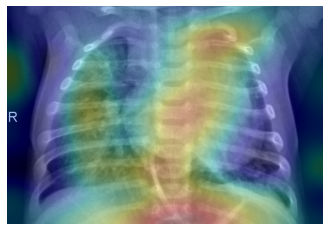

In [ ]:
heatmap=visualize_cam(model1,layer_idx=13
                         ,filter_indices=None
                         ,seed_input=x_test[234],
                          penultimate_layer_idx = penultimate_layer_idx)

heatmap = np.uint8(255 * heatmap)


jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)


save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

plt.imshow(superimposed_img )
plt.axis("Off")

<Figure size 432x288 with 0 Axes>

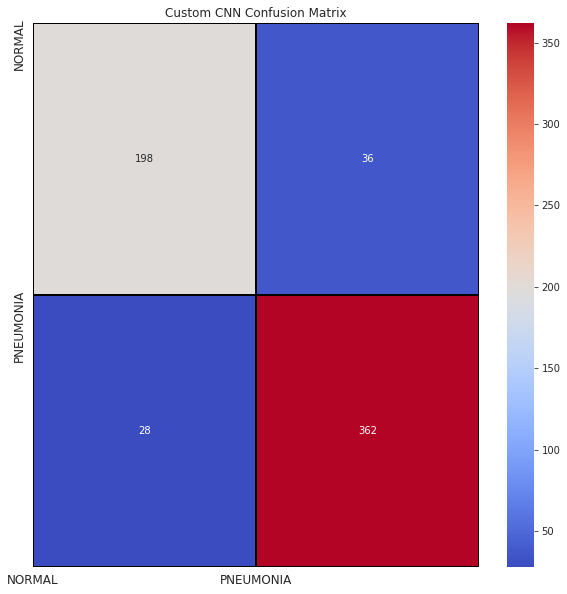

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "coolwarm", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xticks(range(len(labels)), labels, fontsize=12)
plt.yticks(range(len(labels)), labels, fontsize=12)
plt.title("Custom CNN Confusion Matrix")
plt.figure()